# Run an agent based SEIRX simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from mesa.batchrunner import BatchRunner
from os.path import join

import model_SEIRX
import importlib
import viz
importlib.reload(viz)
importlib.reload(model_SEIRX)

# for progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time

## Single model run

In [5]:
N_employees = 10
N_steps = 100
WB = 2
verbosity = 0
seed = 5
G = nx.readwrite.gpickle.read_gpickle('data/WB{}_static_interactions.gpickle'\
                                  .format(WB))
N_patients = len(G.nodes)

SEIRX = model_SEIRX.SIR(G, N_employees, verbosity=verbosity, testing=True, seed=1,
                        screening_interval_patients=10, screening_interval_employees=10,
                       index_case_mode='single')
for i in range(N_steps):
    if verbosity > 0: print('*** step {} ***'.format(i+1))
    #if len([a for a in SEIRX.schedule.agents if \
    #        (a.exposed == True or a.infected == True)]) == 0:
    #    break
    SEIRX.step()

In [6]:
pop_numbers = SEIRX.datacollector.get_model_vars_dataframe()
pop_numbers['S_patient'] = N_patients - pop_numbers.E_patient - pop_numbers.I_patient - pop_numbers.R_patient

In [7]:
#from networkx.drawing.nx_pydot import graphviz_layout
#G = get_transmission_network(SEIRX)
#pos = graphviz_layout(G, prog="dot")
#nx.draw(G, pos)

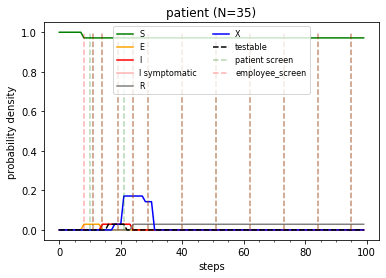

In [8]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_infection_timeline(SEIRX, 'patient', ax)

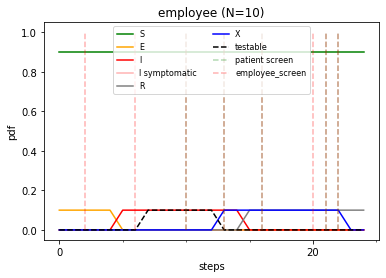

In [16]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_infection_timeline(SEIRX, 'employee', ax)

In [7]:
G = nx.readwrite.gpickle.read_gpickle('testdata/WB{}_static_interactions.gpickle'\
                                  .format(WB))
pos = nx.drawing.layout.spring_layout(G, dim=2, weight='weight')

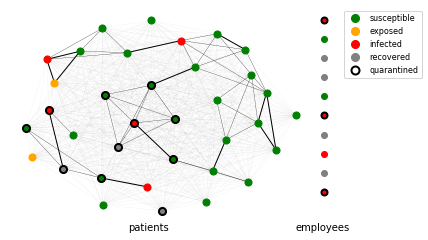

In [8]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_states(SEIRX, 40, pos, ax)

## Model runs

In [10]:
def test_infection(a):
    if a.infected or a.recovered or a.exposed:
        return 1
    else:
        return 0
    
def count_infected(model):
    infected_patients = np.asarray([test_infection(a) for a in model.schedule.agents \
                         if a.type == 'patient']).sum()
    infected_employees = np.asarray([test_infection(a) for a in model.schedule.agents \
                         if a.type == 'employee']).sum()
    
    return infected_employees, infected_patients
    
def calculate_R0(model):
    transmissions = [a.transmissions for a in model.schedule.agents]
    infected = [test_infection(a) for a in model.schedule.agents]
    IDs = [a.ID for a in model.schedule.agents]
    types = [a.type for a in model.schedule.agents]
    df = pd.DataFrame({'ID':IDs,
                       'type':types,
                       'was_infected':infected,
                       'transmissions':transmissions})
    df = df[df['was_infected'] == 1]
    overall_R0 = df['transmissions'].mean()
    patient_R0 = df[df['type'] == 'patient']['transmissions'].mean()
    employee_R0 = df[df['type'] == 'employee']['transmissions'].mean()
    
    return (overall_R0, patient_R0, employee_R0)

def calculate_finite_size_R0(model):
    df = pd.DataFrame(columns=['ID', 'type', 't', 'target'])
    for a in model.schedule.agents:
        if a.transmissions > 0:
            for step, target in a.transmission_targets.items():
                df = df.append({'ID':a.ID, 'type':a.type,
                            't':step, 'target':target},
                            ignore_index=True)
                
    # find first transmission(s)
    # NOTE: while it is very unlikely that two first transmissions occurred
    # in the same timestep, we have to account for the possibility nevertheless
    first_employee_transmitters = df[df['t'] == df['t'].min()]['ID'].values
    N_employee_transmissions = []
    for ft in first_employee_transmitters:
        N_employee_transmissions.append(len(df[df['ID'] == ft]))
        
    # also calculate finite size R_0 for patients
    patient_df = df[df['type'] == 'patient']
    first_patient_transmitters = patient_df[patient_df['t'] == patient_df['t'].min()]['ID'].values
    N_patient_transmissions = []
    for ft in first_patient_transmitters:
        N_patient_transmissions.append(len(df[df['ID'] == ft]))
        
    return np.mean(N_employee_transmissions), np.mean(N_patient_transmissions),  df

def get_transmission_network(model):
    transmissions = []
    for a in model.schedule.agents:
        if a.transmissions > 0:
            for target in a.transmission_targets.values():
                transmissions.append((a.ID, target))
                
    G = nx.Graph()
    G.add_edges_from(transmissions)
                
    return G

In [12]:
res_path = '../../results/nursing_homes'

### Calibration of basic reproduction number (no interventions)

The following transmission settings lead to a reproduction number of $R_{\text{patient},0} = 2.52\pm 1.22$ and $R_{\text{employee},0} = 2.45 \pm 1.27$:
* transmission risk patient $\rightarrow$ patient = 0.008
* transmission risk patient $\rightarrow$ employee = 0.008
* transmission risk employee $\rightarrow$ patient = 0.008
* transmission risk employee $\rightarrow$ employee = 0.008
* transmission area multiplier for patients: zimmer = 7, tisch = 3, wohnbereich = 1
* symptom probability = 0.4, subclinical multiplier = 0.5

In [70]:
print('patients R0 = {:1.3f} +- {:1.3f}'\
      .format(results['patient_R0'].mean(), results['patient_R0'].std()))
print('employees R0 = {:1.3f} +- {:1.3f}'\
      .format(results['employee_R0'].mean(), results['employee_R0'].std())) 

patients R0 = 2.533 +- 1.224
employees R0 = 2.450 +- 1.266


In [53]:
importlib.reload(model_SEIRX)
sim_name = 'basic_reproduction_calibration'
N_employees = 10
N_steps = 300
WB = 2
verbosity = 0
runs = 1000
G = nx.readwrite.gpickle.read_gpickle('../../data/nursing_homes/WB{}_static_interactions.gpickle'\
                                  .format(WB))
N_patients = len(G.nodes)
# progress bar
f = IntProgress(min=0, max=runs) # instantiate the bar
display(f) # display the bar

results = pd.DataFrame(columns=['run', 'employee_R0', 'patient_R0'])
for r in range(runs):
    f.value = r # update the progress bar
    SEIRX = model_SEIRX.SIR(G, N_employees, verbosity, testing=False)
    for i in range(N_steps):
        if verbosity > 0: print('*** step {} ***'.format(i+1))
        SEIRX.step()
        if len([a for a in SEIRX.schedule.agents if a.recovered == True]) > 35:
            break
        
    employee_R0, patient_R0, _ = calculate_finite_size_R0(SEIRX)
    
    results = results.append({'run':r, 
                              'employee_R0':employee_R0,
                              'patient_R0':patient_R0},
                            ignore_index=True)
    
results.to_csv(join(res_path, 'simulation_results/{}.csv'.format(sim_name)),
               index=False)

IntProgress(value=0, max=1000)

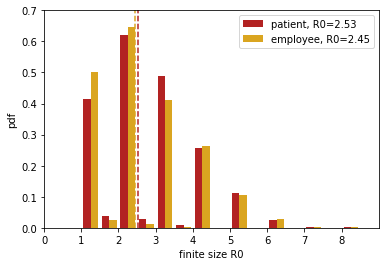

In [76]:
sim_name = 'basic_reproduction_calibration'
fig, ax = plt.subplots()
patient_R0 = results['patient_R0'].mean()
employee_R0 = results['employee_R0'].mean()

ax.hist([results['patient_R0'], results['employee_R0']], \
                  label=['patient, R0={:1.2f}'.format(patient_R0),
                         'employee, R0={:1.2f}'.format(employee_R0)],
                  bins=np.arange(0, 9, 0.5), density=True,
                  color=['FireBrick', 'GoldenRod'])
ax.plot([patient_R0, patient_R0], [0, 0.7], '--', color='FireBrick')
ax.plot([employee_R0, employee_R0], [0, 0.7], '--', color='GoldenRod')
ax.legend()
ax.set_xticks(range(0, 9))
ax.set_xlabel('finite size R0')
ax.set_ylabel('pdf')
ax.set_ylim(0, 0.7)
ax.set_xlim(0, 9)

plt.savefig(join(res_path, 'plots/{}.pdf'.format(sim_name)),
                 transparent=True)

### Test result duration scan

In [113]:
importlib.reload(model_SEIRX)
sim_name = 'test_result_duration'
N_employees = 10
N_steps = 300
WB = 2
verbosity = 0
runs = 500
t_scan_range = [0, 1, 2]
i_scan_range = [0.001, 0.05, 0.01, 0.15]
G = nx.readwrite.gpickle.read_gpickle('../../data/nursing_homes/WB{}_static_interactions.gpickle'\
                                  .format(WB))
N_patients = len(G.nodes)
# progress bar
f = IntProgress(min=0, max=runs * len(t_scan_range) * len(i_scan_range)) # instantiate the bar
display(f) # display the bar

scan_results = pd.DataFrame()
c=0
for index_prob in i_scan_range:
    for t in t_scan_range:
        print(t)
        ensemble_results = pd.DataFrame(columns=['run', 'employee_R0', 'patient_R0',
                                                'infected_patients', 'infected_employees'])
        for r in range(runs):
            f.value = c # update the progress bar
            c += 1
            SEIRX = model_SEIRX.SIR(G, N_employees, verbosity, testing=True,
                                    time_until_test_result=t, index_probability=index_prob)
            for i in range(N_steps):
                if verbosity > 0: print('*** step {} ***'.format(i+1))
                SEIRX.step()
                if len([a for a in SEIRX.schedule.agents if a.recovered == True]) > len(G.nodes) + N_employees:
                    break

            employee_R0, patient_R0, _ = calculate_finite_size_R0(SEIRX)
            infected_employees, infected_patients = count_infected(SEIRX)

            ensemble_results = ensemble_results.append({'run':r, 
                                      'employee_R0':employee_R0,
                                      'patient_R0':patient_R0,
                                      'infected_patients':infected_patients,
                                      'infected_employees':infected_employees},
                                    ignore_index=True)
        scan_results = scan_results.append({'test_result_delay':t,
                                            'index_case_probability':index_prob,
                                            'R0_patient_mean':ensemble_results['patient_R0'].mean(),
                                            'R0_patient_std':ensemble_results['patient_R0'].std(),
                                            'R0_employee_mean':ensemble_results['employee_R0'].mean(),
                                            'R0_employee_std':ensemble_results['employee_R0'].std() ,
                                            'infected_patients_mean':ensemble_results['infected_patients'].mean(),
                                            'infected_patients_std':ensemble_results['infected_patients'].std(),
                                            'infected_employees_mean':ensemble_results['infected_employees'].mean(),
                                            'infected_employees_std':ensemble_results['infected_employees'].std()},
                                          ignore_index=True)
    
scan_results.to_csv(join(res_path,'simulation_results/{}.csv'.format(sim_name)),
                         index=False)

IntProgress(value=0, max=6000)

0


/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
0
1
2
0
1
2
0
1
2


### Preventive screening frequency scan

In [21]:
importlib.reload(model_SEIRX)
sim_name = 'preventive_screening_interval'
N_employees = 10
N_steps = 300
WB = 2
verbosity = 0
runs = 10000
p_screen_range = [2, 3, 7, None]
e_screen_range = [2, 3, 7, None]
test_durations = [0, 1, 2]
G = nx.readwrite.gpickle.read_gpickle('../../data/nursing_homes/WB{}_static_interactions.gpickle'\
                                  .format(WB))
N_patients = len(G.nodes)
# progress bar
f = IntProgress(min=0, max=runs * len(p_screen_range) \
                * len(e_screen_range) * len(test_durations)) # instantiate the bar
display(f) # display the bar

scan_results = pd.DataFrame()
c=0
for td in test_durations:
    for p_screen_interval in p_screen_range:
        for e_screen_interval in e_screen_range:
            ensemble_results = pd.DataFrame(columns=['run', 'employee_R0', 'patient_R0',
                                                    'infected_patients', 'infected_employees',
                                                    'N_patient_screens', 'N_employee_screens',
                                                    'duration'])
            for r in range(runs):
                f.value = c # update the progress bar
                c += 1
                SEIRX = model_SEIRX.SIR(G, N_employees, verbosity, testing=True,
                                        time_until_test_result = td,
                                        screening_interval_patients = p_screen_interval,
                                        screening_interval_employees = e_screen_interval,
                                        index_case_mode = 'single')
                for i in range(N_steps):
                    SEIRX.step()
                    # break if first outbreak is over
                    if len([a for a in SEIRX.schedule.agents if \
                        (a.exposed == True or a.infected == True)]) == 0:
                        break
                        
                employee_R0, patient_R0, _ = calculate_finite_size_R0(SEIRX)
                infected_employees, infected_patients = count_infected(SEIRX)
                data = SEIRX.datacollector.get_model_vars_dataframe()
                num_patient_screens = data['screen_patients'].sum()
                num_employee_screens = data['screen_employees'].sum()
                duration = len(data)

                ensemble_results = ensemble_results.append({'run':r, 
                                          'employee_R0':employee_R0,
                                          'patient_R0':patient_R0,
                                          'infected_patients':infected_patients,
                                          'infected_employees':infected_employees,
                                          'N_patient_screens':num_patient_screens,
                                          'N_employee_screens':num_employee_screens,
                                          'duration':duration},
                                        ignore_index=True)
                
            scan_results = scan_results.append({'test_result_duration':td,
                                                'patient_screen_interval':p_screen_interval,
                                                'employee_screen_interval':e_screen_interval,
                                                'R0_patient_mean':ensemble_results['patient_R0'].mean(),
                                                'R0_patient_median':ensemble_results['patient_R0'].median(),
                                                'R0_patient_0.25':ensemble_results['patient_R0'].quantile(0.25),
                                                'R0_patient_0.75':ensemble_results['patient_R0'].quantile(0.75),
                                                'R0_patient_std':ensemble_results['patient_R0'].std(),
                                                'R0_employee_mean':ensemble_results['employee_R0'].mean(),
                                                'R0_employee_median':ensemble_results['employee_R0'].median(),
                                                'R0_employee_0.25':ensemble_results['employee_R0'].quantile(0.25),
                                                'R0_employee_0.75':ensemble_results['employee_R0'].quantile(0.75),
                                                'R0_employee_std':ensemble_results['employee_R0'].std() ,
                                                'infected_patients_mean':ensemble_results['infected_patients'].mean(),
                                                'infected_patients_median':ensemble_results['infected_patients'].median(),
                                                'infected_patients_0.25':ensemble_results['infected_patients'].quantile(0.25),
                                                'infected_patients_0.75':ensemble_results['infected_patients'].quantile(0.75),
                                                'infected_patients_std':ensemble_results['infected_patients'].std(),
                                                'infected_employees_mean':ensemble_results['infected_employees'].mean(),
                                                'infected_employees_median':ensemble_results['infected_employees'].median(),
                                                'infected_employees_0.25':ensemble_results['infected_employees'].quantile(0.25),
                                                'infected_employees_0.95':ensemble_results['infected_employees'].quantile(0.95),
                                                'infected_employees_std':ensemble_results['infected_employees'].std(),
                                                'N_patient_screens_mean':ensemble_results['N_patient_screens'].mean(),
                                                'N_patient_screens_median':ensemble_results['N_patient_screens'].median(),
                                                'N_patient_screens_0.25':ensemble_results['N_patient_screens'].quantile(0.25),
                                                'N_patient_screens_0.75':ensemble_results['N_patient_screens'].quantile(0.75),
                                                'N_patient_screens_std':ensemble_results['N_patient_screens'].std(),
                                                'N_employee_screens_mean':ensemble_results['N_employee_screens'].mean(),
                                                'N_employee_screens_median':ensemble_results['N_employee_screens'].median(),
                                                'N_employee_screens_0.25':ensemble_results['N_employee_screens'].quantile(0.25),
                                                'N_employee_screens_0.75':ensemble_results['N_employee_screens'].quantile(0.75),
                                                'N_employee_screens_std':ensemble_results['N_employee_screens'].std(),
                                                'duration_mean':ensemble_results['duration'].mean(),
                                                'duration_median':ensemble_results['duration'].median(),
                                                'duration_0.25':ensemble_results['duration'].quantile(0.25),
                                                'duration_0.75':ensemble_results['duration'].quantile(0.75),
                                                'duration_std':ensemble_results['duration'].std()},
                                              ignore_index=True)
    
scan_results.to_csv(join(res_path,'simulation_results/{}_N{}.csv'.format(sim_name, runs)), ignore_index=False)

IntProgress(value=0, max=480000)

/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: to_csv() got an unexpected keyword argument 'ignore_index'

In [24]:
scan_results.to_csv(join(res_path,'simulation_results/{}_N{}.csv'.format(sim_name, runs)), index=False)

In [27]:
scan_results_reordered = scan_results[['test_result_duration', 'patient_screen_interval', 'employee_screen_interval', 'infected_patients_0.25', 'infected_patients_0.75',
       'infected_patients_mean', 'infected_patients_median', 'infected_patients_std', 'employee_screen_interval', 'infected_employees_0.25',
       'infected_employees_0.95', 'infected_employees_mean', 'infected_employees_median', 'infected_employees_std','R0_patient_0.25', 'R0_patient_0.75',
       'R0_patient_mean', 'R0_patient_median', 'R0_patient_std', 'R0_employee_0.25',
       'R0_employee_0.75', 'R0_employee_mean', 'R0_employee_median','N_employee_screens_0.25', 'N_employee_screens_0.75',
       'N_employee_screens_mean', 'N_employee_screens_median',
       'N_employee_screens_std', 'N_patient_screens_0.25',
       'N_patient_screens_0.75', 'N_patient_screens_mean',
       'N_patient_screens_median', 'N_patient_screens_std','duration_0.25', 'duration_0.75', 'duration_mean', 'duration_median',
       'duration_std']].copy()

In [31]:
scan_results_reordered.to_csv(join(res_path,'simulation_results/{}_N{}.csv'.format(sim_name, runs)), index=False)

In [29]:
scan_results.shape

(48, 38)

In [26]:
scan_results.columns

Index(['N_employee_screens_0.25', 'N_employee_screens_0.75',
       'N_employee_screens_mean', 'N_employee_screens_median',
       'N_employee_screens_std', 'N_patient_screens_0.25',
       'N_patient_screens_0.75', 'N_patient_screens_mean',
       'N_patient_screens_median', 'N_patient_screens_std', 'R0_employee_0.25',
       'R0_employee_0.75', 'R0_employee_mean', 'R0_employee_median',
       'R0_employee_std', 'R0_patient_0.25', 'R0_patient_0.75',
       'R0_patient_mean', 'R0_patient_median', 'R0_patient_std',
       'duration_0.25', 'duration_0.75', 'duration_mean', 'duration_median',
       'duration_std', 'employee_screen_interval', 'infected_employees_0.25',
       'infected_employees_0.95', 'infected_employees_mean',
       'infected_employees_median', 'infected_employees_std',
       'infected_patients_0.25', 'infected_patients_0.75',
       'infected_patients_mean', 'infected_patients_median',
       'infected_patients_std', 'patient_screen_interval',
       'test_result_dur

## Batch run

In [117]:
importlib.reload(model_SEIRX)
fixed_params = {'G':G, 'num_employees':N_employees, 'verbosity':0}
variable_params = {'infection_duration':range(11, 14)}
#variable_params = {}

model_reporters = {'E_patient':model_SEIRX.count_E_patient,
                   'I_patient':model_SEIRX.count_I_patient,
                   'I_symptomatic_patient':model_SEIRX.count_I_symptomatic_patient,
                   'R_patient':model_SEIRX.count_R_patient,
                   'X_patient':model_SEIRX.count_X_patient,
                   'T_patient':model_SEIRX.count_T_patient,
                   'E_employee':model_SEIRX.count_E_employee,
                   'I_employee':model_SEIRX.count_I_employee,
                   'I_symptomatic_employee':model_SEIRX.count_I_symptomatic_employee,
                   'R_employee':model_SEIRX.count_R_employee,
                   'X_employee':model_SEIRX.count_X_employee,
                   'T_employee':model_SEIRX.count_T_employee,
                   'screen':model_SEIRX.check_screen}

batch_run = BatchRunner(model_SEIRX.SIR,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100)
batch_run.run_all()

15it [00:00, 38.83it/s]


In [118]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()

AttributeError: 'BatchRunner' object has no attribute 'model_vars'

In [120]:
import mesa
mesa.__version__

'0.8.7'

In [100]:
from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [102]:
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=1,
                        max_steps=20,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

49it [00:02, 16.73it/s]
